In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import os, sys, glob
import matplotlib.pyplot as plt
import seaborn as sns
import utils, config
import scprep, phate
import matplotlib.pyplot as plt
import matplotlib as mpl
import embedding_helpers as mf
import matplotlib.patches as patches
import scipy.stats as stats
import statistics_helpers as mystats
import phate, demap
import embedding_helpers as mf
import utils
import matplotlib


np.random.seed(64)
## colormaps from lightest to darkest
evis_colors = ["#FFFFFF","#E9B0D2", "#DE88BC", "#D360A5", "#AF4F88"]
hvis_colors = ["#FFFFFF","#CCB2D5", "#B28BC0","#9864AB","#7D538D"]
aud_colors = ["#FFFFFF",'#D1F0F2','#A2E1E4',"#44C2C9","#38A0A6"]
pmc_colors = ["#FFFFFF","#B1DFB1","#8DD18D","#58BB58","#499B49"]
big_colors = ["#AF4F88", "#7D538D", "#38A0A6", "#499B49"]

colors_dict = {'voxel':0, 'PCA':1, 'UMAP':2, "PHATE":3, "TPHATE":4, "PHATE_TIME":1, "SMOOTH_PHATE":3, 
              "ISOMAP":1, "LLE":2, "TSNE":3}

evis_3colors = ["#E9B0D2", "#DE88BC", "#AF4F88"]
hvis_3colors = ["#CCB2D5", "#B28BC0","#7D538D"]
aud_3colors = ['#D1F0F2','#A2E1E4',"#38A0A6"]
pmc_3colors = ["#B1DFB1","#8DD18D","#499B49"]

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# from seaborn.algorithms import bootstrap
# bootstrap(arr, n_boot=1000)

/gpfs/milgram/project/casey/elb77/conda_envs/tphate_env/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


# Figure 1

## plot autocorrelation function

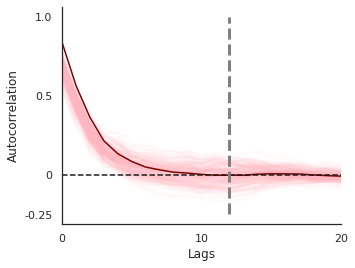

<Figure size 432x288 with 0 Axes>

In [32]:
import statsmodels.api as sm
data = utils.load_sherlock_movie_ROI_data('early_visual',[7])[0]
smooth_window=2
A_vox = np.empty_like(data)
n_timepoints, n_voxels = data.shape
for v in range(n_voxels):
    x = data[:, v]
    A_vox[:, v] = sm.tsa.acf(x, fft=False, nlags=len(x)-1)

A_avg = np.mean(A_vox, axis=1)
y = np.convolve(A_avg, np.ones(smooth_window), 'same') / smooth_window
dropoff=np.where(y < 0)[0][0]
sns.set(style='white')
fig,ax=plt.subplots(1,1,figsize=(5,4))
_=ax.plot(A_vox[1:56], alpha=0.05, c='lightpink')
ax.plot(y[1:56], c='maroon')
ax.axhline(0, color='k', linestyle='--')
sns.despine(top=True,right=True)
ax.set(xlim=[0,20], xlabel='Lags', ylabel="Autocorrelation")
ax.set(xticks=np.arange(0,21,10), yticks=[-0.25,0,0.25,0.5,0.75,1.0], yticklabels=[-0.25,0,'',0.5,'',1.0])
ax.plot([dropoff,dropoff],[-0.25,1.0],'gray',ls='--',linewidth=3)
plt.show()
plt.savefig('../plots/final_plots/autocorr_function_method.pdf', format='pdf', 
            transparent=True,bbox_inches = "tight")

## Figure 1 C

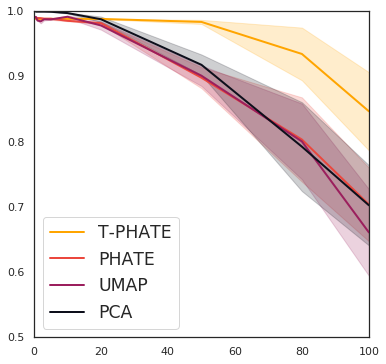

In [109]:
d1 = pd.read_csv("../results_final/demap_simulation_results.csv")

fig,ax=plt.subplots(figsize=(6,6))
g=sns.lineplot(data=d1, x='sigma', y='rho', hue='method', ci=90, linewidth=2,
               hue_order=['TPHATE','PHATE','UMAP',"PCA"],
             palette=["orange", '#EB473D', '#9B1F5D','#0D0F1B'])

plt.legend(labels=["T-PHATE",'PHATE',"UMAP",'PCA'], title = "",
           fontsize = 'x-large', loc='lower left')

g.set_ylabel("",Fontsize="large")
g.set_xlabel("",Fontsize="large")
g.set(ylim=[0.5,1], xlim=[0,100])

plt.savefig('../plots/final_plots/demap_simulation_result_main.pdf', bbox_inches = "tight",transparent=True, format='pdf')


## Supplementary figure 1B

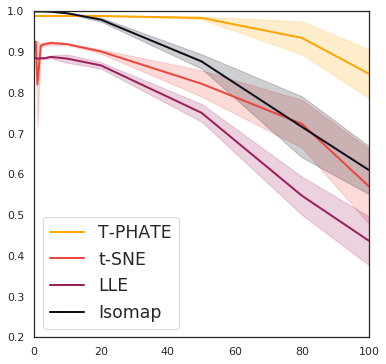

In [111]:
d1 = pd.read_csv("../results_final/demap_simulation_results.csv")

fig,ax=plt.subplots(figsize=(6,6))
g=sns.lineplot(data=d1, x='sigma', y='rho', hue='method', ci=90, linewidth=2,
               hue_order=['TPHATE','TSNE','LLE',"ISOMAP"],
             palette=["orange", '#EB473D', '#9B1F5D','#0D0F1B'])

plt.legend(labels=["T-PHATE",'t-SNE',"LLE",'Isomap'], title = "",
           fontsize = 'x-large', loc='lower left')

g.set_ylabel("",Fontsize="large")
g.set_xlabel("",Fontsize="large")
g.set(ylim=[0.2,1], xlim=[0,100])

plt.savefig('../plots/final_plots/demap_simulation_result_supp.pdf', bbox_inches = "tight",transparent=True, format='pdf')


In [2]:
def boxplot_all_methods(dataframe, dataset, yname, outfn, methods, 
                        method_label=None, ylabel=None, ROIs=None, ylim=None, 
                        logscale=False, yax=False, figsize=(6,6), draw_signif=True):
    if not ylabel:
        ylabel = yname
    if not ROIs:
        ROIs=config.ROIs
    if not method_label:
        method_label = 'embed_method'
    
    COLOR_IDX = sorted([colors_dict[method] for method in methods])
    ROI_codes = {'early_visual':'EV', 'high_Visual':"HV", 'aud_early':"EA", 'pmc_nn':'PMC'}
    X_LABELS = [ROI_codes[r] for r in ROIs]
    df = dataframe[(dataframe['dataset']==dataset) & (dataframe[method_label].isin(methods)) & (dataframe['ROI'].isin(ROIs))]
    fig,ax=plt.subplots(figsize=figsize, dpi=100)

    sns.set(style='white')
    g=sns.boxplot(data=df,  x='ROI', y=yname,
                hue=method_label, ci=None, n_boot=1000, errwidth=0.8, edgecolor=big_colors,
                hue_order=methods,order=ROIs, ax=ax)
    ax.get_legend().remove()
    if dataset == 'sherlock':
        title="$\it{Sherlock}$ movie dataset"
    else:
        title="$\it{StudyForrest}$ movie dataset"
    
    g.set(xlabel='', ylabel=ylabel, title=title)
    g.set_xticklabels(X_LABELS, fontsize=16)
    
    if ylim != None and len(ylim)>2:
        g.set(yticks=ylim)
    else:
        g.set(ylim=ylim)
        
    if logscale:
        ax.set_yscale('log')
    if yax:
        ax.axhline(0, color='k', linestyle='--')

    colors_in_order = []
    edge_colors = []
    embd_roi = []
    COLORMAPS = {'EV': [evis_colors[r] for r in COLOR_IDX],
                'HV': [hvis_colors[r] for r in COLOR_IDX],
                'EA': [aud_colors[r] for r in COLOR_IDX], 
                'PMC':[pmc_colors[r] for r in COLOR_IDX]}
    
    COLORMAPS=[COLORMAPS[X] for X in X_LABELS]
    for i in range(len(COLOR_IDX)):
        for j, cmap in enumerate(COLORMAPS):
            colors_in_order.append(cmap[i])
            edge_colors.append(cmap[-1])
            embd_roi.append([methods[i], ROIs[j]])
    
    i = 0
    for container, METHOD in zip(g.containers, methods):    
        for c, patch in enumerate(container):
            patch.set_color(colors_in_order[i])
            patch.set_edgecolor(edge_colors[i])
            w = patch.get_width()/2
            x, y = patch.xy
            r = ROIs[c] 
#             points = df[(df[method_label]==METHOD) & (df['ROI']==r)]['zstat'].values

#             ax.scatter(x=np.repeat(x+w, len(points)), y=points, edgecolors='k', 
#                        zorder=10, linewidths=0.6, s=12, c=colors_in_order[i])

            
            i+=1
    sns.despine(top=True, right=True)
    
    if ylim != None:
        if ylim[0] < 0 and 0 < ylim[1]:
            ax.axhline(0, color='k', linestyle='--')
            

    if outfn is not None:
        plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')
        plt.clf()
    else:
        return fig
    

In [3]:
def barplot_scatter_all_methods(dataframe, dataset, yname, outfn, methods, 
                        method_label=None, ylabel=None, ROIs=None, ylim=None, 
                        logscale=False, yax=False, figsize=(6,6), draw_signif=True, scatter=True):
    if not ylabel:
        ylabel = yname
    if not ROIs:
        ROIs=config.ROIs
    if not method_label:
        method_label = 'embed_method'
    
    COLOR_IDX = sorted([colors_dict[method] for method in methods])
    ROI_codes = {'early_visual':'EV', 'high_Visual':"HV", 'aud_early':"EA", 'pmc_nn':'PMC'}
    X_LABELS = [ROI_codes[r] for r in ROIs]
    df = dataframe[(dataframe['dataset']==dataset) & (dataframe[method_label].isin(methods)) & (dataframe['ROI'].isin(ROIs))]
    fig,ax=plt.subplots(figsize=figsize, dpi=100)

    sns.set(style='white')
    g=sns.barplot(data=df,  x='ROI', y=yname,
                hue=method_label, ci=95, n_boot=1000,capsize=.05, errwidth=1.5, edgecolor=big_colors,
                hue_order=methods,order=ROIs, ax=ax)
    ax.get_legend().remove()
    if dataset == 'sherlock':
        title="$\it{Sherlock}$ movie dataset"
    else:
        title="$\it{StudyForrest}$ movie dataset"
    
    g.set(xlabel='', ylabel=ylabel, title=title)
    g.set_xticklabels(X_LABELS, fontsize=16)
    
    if ylim != None and len(ylim)>2:
        g.set(yticks=ylim)
    else:
        g.set(ylim=ylim)
        
    if logscale:
        ax.set_yscale('log')
    if yax:
        ax.axhline(0, color='k', linestyle='--')

    colors_in_order = []
    edge_colors = []
    embd_roi = []
    COLORMAPS = {'EV': [evis_colors[r] for r in COLOR_IDX],
                'HV': [hvis_colors[r] for r in COLOR_IDX],
                'EA': [aud_colors[r] for r in COLOR_IDX], 
                'PMC':[pmc_colors[r] for r in COLOR_IDX]}
    
    COLORMAPS=[COLORMAPS[X] for X in X_LABELS]
    for i in range(len(COLOR_IDX)):
        for j, cmap in enumerate(COLORMAPS):
            colors_in_order.append(cmap[i])
            edge_colors.append(cmap[-1])
            embd_roi.append([methods[i], ROIs[j]])
    
    i = 0
    for container, METHOD in zip(g.containers, methods):    
        for c, patch in enumerate(container):
            patch.set_color(colors_in_order[i])
            patch.set_edgecolor(edge_colors[i])
            if scatter:
                w = patch.get_width()/2
                x, y = patch.xy
                r = ROIs[c] 
                points = df[(df[method_label]==METHOD) & (df['ROI']==r)][yname].values

                ax.scatter(x=np.repeat(x+w, len(points)), y=points, edgecolors='k', 
                           zorder=10, linewidths=0.4, s=16, c=colors_in_order[i])

            
            i+=1
    sns.despine(top=True, right=True)
    
    if ylim != None:
        if ylim[0] < 0 and 0 < ylim[1]:
            ax.axhline(0, color='k', linestyle='--')
            

    if outfn is not None:
        plt.savefig(outfn, bbox_inches = "tight",transparent=True, format='pdf')
        plt.clf()
    else:
        return fig
    

In [4]:
import statistics_helpers as mystats

def run_stats(dataframe, ROIs, yname, other_methods, alt='greater'):
    stat_df = pd.DataFrame(columns=['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
    n_tests = len(other_methods)

    for ROI in ROIs:
        df_here = dataframe[dataframe['ROI'] == ROI]
        tphate_vals = df_here[df_here['embed_method']=='TPHATE'][yname].values
        for other_method in other_methods:
            try:
                other_vals = df_here[df_here['embed_method']==other_method][yname].values
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                corrected_p = mystats.correct_pvalue(pval, n_tests)
            
            except:
                print(ROI, other_method)
                corrected_p, observed, pval = np.nan, np.nan, np.nan
            stat_df.loc[len(stat_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected_p}
    return stat_df
            

## Movie SVC Figures

In [44]:
df = pd.read_csv("../results_final/SVC_movie_features_results.csv", index_col=0)
methods = ['voxel','PCA','UMAP','PHATE','TPHATE']
RANGES = {'sherlock':[-0.5, 10], 'forrest':[-2,3]}
stat_df = pd.DataFrame(columns=['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected','feature'])
for dataset in df.dataset.unique():
    sub_df = df[df['dataset']==dataset]
    RANGE = RANGES[dataset]
    for feat in sub_df.regressor.unique():
        d1 = df[(df['embed_method'].isin(methods)) & (df['regressor']==feat)]
        ylabel='zstat'
        method_label = 'embed_method'
        fn=f'../plots/final_plots/{dataset}_{feat}_svc_main_with_scatter.pdf'
        #fn=None
        barplot_scatter_all_methods(d1, dataset, 'zstat', outfn=fn, methods=methods, 
                                method_label=method_label, ylabel='z-score', ROIs=None, ylim=RANGE, 
                                logscale=False, yax=False, figsize=(6,6))
#         break
        ## Run stats
        stats = run_stats(d1, d1.ROI.unique(), "zstat", [m for m in methods if m is not "TPHATE"], alt='greater')
        stats['feature']=np.repeat(feat, len(stats))
        stat_df = pd.concat([stat_df, stats])
stat_df.to_csv("../results_final/SVC_movie_stats.csv")

aud_early voxel
aud_early voxel


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# localizer SVC Figures


In [56]:
df = pd.read_csv('../results_final/SVC_localizer_results.csv',index_col=0)

stats_df = pd.DataFrame(columns=['ROI','dataset','comparison','yname','observed_diff',
                                 'pvalue_uncorrected','pvalue_corrected'])
df['dataset']=np.repeat('forrest', len(df))
for ROI in ['early_visual','high_Visual']:
    df_here2 = df[df['ROI']==ROI]
    n_tests = 2
    tphate_vals = df_here2[df_here2['embed_method']=='TPHATE']['clf_accuracy'].values
    for other_method in ['PHATE_TIME', 'SMOOTH_PHATE']:
        other_vals = df_here2[df_here2['embed_method']==other_method]['clf_accuracy'].values
        observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
        corrected = mystats.correct_pvalue(pval, n_tests)
        stats_df.loc[len(stats_df)] = {'ROI':ROI, 'comparison':f'TPHATE_v_{other_method}', 
                                      'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                      'pvalue_corrected':corrected}
        print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
    n_tests=3
    for other_method in ['ISOMAP', "LLE", 'TSNE']:
        other_vals = df_here2[df_here2['embed_method']==other_method]['clf_accuracy'].values
        observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
        corrected = mystats.correct_pvalue(pval, n_tests)
        stats_df.loc[len(stats_df)] = {'ROI':ROI, 'comparison':f'TPHATE_v_{other_method}', 
                                      'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                      'pvalue_corrected':corrected}
        print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')

        
barplot_scatter_all_methods(df, 'forrest', 'clf_accuracy', '../plots/final_plots/localizer_clf_supp.pdf', 
                            ['ISOMAP', "LLE", 'TSNE',  'TPHATE'], 
                    ROIs=['early_visual','high_Visual'],
                            ylim=[0,0.7])
barplot_scatter_all_methods(df, 'forrest', 'clf_accuracy', '../plots/final_plots/localizer_clf_main.pdf', 
                            ['PHATE_TIME', "SMOOTH_PHATE", 'TPHATE'], 
                    ROIs=['early_visual','high_Visual'],
                            ylim=[0,0.7])


# for ROI in ['early_visual','high_Visual']:
#     df_here2 = df[df['ROI']==ROI]
#     n_tests = 2
#     tphate_vals = df_here2[df_here2['embed_method']=='TPHATE']['clf_accuracy'].values
#     for other_method in ['ISOMAP',"LLE"]:
#         other_vals = df_here2[df_here2['embed_method']==other_method]['clf_accuracy'].values
#         try:
#             observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative='greater')
#         except:
#             print(f'failed on {other_method}')
#         corrected = mystats.correct_pvalue(pval, n_tests)
#         stats_df.loc[len(stats_df)] = {'ROI':ROI, 'comparison':f'TPHATE_v_{other_method}', 
#                                       'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
#                                       'pvalue_corrected':corrected}
#         print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')


early_visual forrest PHATE_TIME CV_M pc=0.01 pu=0.005
early_visual forrest SMOOTH_PHATE CV_M pc=0.002 pu=0.001
early_visual forrest ISOMAP CV_M pc=0.003 pu=0.001
early_visual forrest LLE CV_M pc=0.003 pu=0.001
early_visual forrest TSNE CV_M pc=0.006 pu=0.002
high_Visual forrest PHATE_TIME CV_M pc=0.002 pu=0.001
high_Visual forrest SMOOTH_PHATE CV_M pc=0.002 pu=0.001
high_Visual forrest ISOMAP CV_M pc=0.003 pu=0.001
high_Visual forrest LLE CV_M pc=0.003 pu=0.001
high_Visual forrest TSNE CV_M pc=0.003 pu=0.001


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# Within-subject HMM results optimize M



In [5]:
df = pd.read_csv('../results_final/within_subject_HMM_results.csv',index_col=0)

df['neg_LL'] = df['model_LogLikelihood'].values * -1
print(np.sum(df['AIC']!=df['AIC']))

df.to_csv('../results_final/within_subject_HMM_results.csv')
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

ranges = {'sherlock':{'difference_score':(0,0.6), 'AIC':(4000, 12000), 'neg_LL':(1600,3800)}, 
         'forrest': {'difference_score':(-0.01,0.3), 'AIC':(14000, 42500), 'neg_LL':(3000,7000)}}

for dataset in config.DATASETS:
    for yname in ['difference_score','AIC','neg_LL']:
        logsc = True if yname != 'difference_score' else False
        
        alt = 'less' if yname != 'difference_score' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/final_plots/{dataset}_{yname}_within_subj_hmm_optimizeM.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            ["voxel",'PCA','UMAP','PHATE','TPHATE'], 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        
        # now do permutation tests
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 4
            for other_method in ["voxel",'PCA','UMAP','PHATE']:
                other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
                try:
                    observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                except:
                    print(f'failed {ROI} {dataset} {other_method} {yname}')
                    continue
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                #print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/within_subject_HMM_stats.csv")

0


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [7]:
df = pd.read_csv('../results_final/within_subject_HMM_results.csv',index_col=0)
ranges = {'sherlock':{'difference_score':(0,0.6), 'AIC':(4000, 12000), 'neg_LL':(1600,3800)}, 
         'forrest': {'difference_score':(-0.01,0.3), 'AIC':(14000, 42500), 'neg_LL':(3000,7000)}}
methods = ['PHATE_TIME','SMOOTH_PHATE','TPHATE']
for dataset in config.DATASETS:
    for yname in ['difference_score']:#,'AIC','neg_LL']:
        logsc = True if yname != 'difference_score' else False
        
        alt = 'less' if yname != 'difference_score' else 'greater'
        methods = ['PHATE_TIME','SMOOTH_PHATE','TPHATE']
    
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/final_plots/{dataset}_{yname}_within_subj_hmm_optimizeM_supp_time.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            methods, 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        methods = ['ISOMAP','LLE','TSNE','TPHATE']

        fn=f'../plots/final_plots/{dataset}_{yname}_within_subj_hmm_optimizeM_supp_methods.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            methods, 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# Within-subject HMM results control M


In [47]:
df = pd.read_csv('../results_final/within_subject_HMM_controlM_results.csv',index_col=0)

stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])

df['neg_LL'] = df['model_LogLikelihood'].values * -1
ranges = {'sherlock':{'avg_difference':(0,0.7), 'AIC':(3000, 11000), 'neg_LL':(1300,3300)}, 
         'forrest': {'avg_difference':(0,0.25), 'AIC':(15000, 40000), 'neg_LL':(2700,6000)}}


for dataset in config.DATASETS:
    for yname in ['avg_difference','AIC','neg_LL']:
        logsc = True if yname != 'avg_difference' else False
        
        alt = 'less' if yname != 'avg_difference' else 'greater'
            
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/final_plots/{dataset}_{yname}_within_subj_hmm_controlM.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            ['PCA','UMAP','PHATE','TPHATE'], 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset][yname])
        
        for ROI in ROIs_here:
            df_here2 = df_here[df_here['ROI']==ROI]
            tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
            n_tests = 3
            for other_method in ['PCA','UMAP','PHATE']:
                other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
                observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
                corrected = mystats.correct_pvalue(pval, n_tests)
                stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                              'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                              'pvalue_corrected':corrected}
                #print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/within_subject_HMM_stats_controlM.csv")

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# between subject HMM , optimize M

In [48]:
df = pd.read_csv('../results_final/between_subject_HMM_results.csv',index_col=0)

stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
ranges={'sherlock':[-0.02,0.12], 'forrest':[-0.02,0.12]}
yname = 'avg_diff'
for dataset in config.DATASETS:
    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/final_plots/{dataset}_{yname}_between_subj_hmm_optimizeM.pdf'
    barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                        ["voxel",'PCA','UMAP','PHATE','TPHATE'], 
                        ROIs=ROIs_here, logscale=False, 
                       ylim=ranges[dataset])
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 4
        for other_method in ['voxel','PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            #print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/between_subject_HMM_stats_optimizeM.csv")

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

In [9]:
df = pd.read_csv('../results_final/between_subject_HMM_results.csv',index_col=0)
ranges={'sherlock':[-0.02,0.12], 'forrest':[-0.02,0.12]}

methods = ['PHATE_TIME','SMOOTH_PHATE','TPHATE']
for dataset in config.DATASETS:
    for yname in ['avg_diff']:#,'AIC','neg_LL']:
#         logsc = True if yname != 'difference_score' else False
        
#         alt = 'less' if yname != 'difference_score' else 'greater'
        methods = ['PHATE_TIME','SMOOTH_PHATE','TPHATE']
    
        df_here = df[(df['dataset']==dataset)]        
        ROIs_here = config.ROIs
        fn=f'../plots/final_plots/{dataset}_{yname}_btwn_subj_hmm_optimizeM_supp_time.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            methods, 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset])
        methods = ['ISOMAP','LLE','TSNE','TPHATE']

        fn=f'../plots/final_plots/{dataset}_{yname}_btwn_subj_hmm_optimizeM_supp_methods.pdf'
        barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                            methods, 
                            ROIs=ROIs_here, logscale=False, 
                           ylim=ranges[dataset])
        

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# behavioral segmentation, optimize M

In [50]:
df = pd.read_csv('../results_final/behavior_event_boundaries.csv',index_col=0)
df['dataset']=np.repeat('sherlock',len(df))
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
ranges={'sherlock':[-0.02,0.15]}
yname = 'avg_difference'
for dataset in ['sherlock']:
    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/final_plots/{dataset}_{yname}_behav_optimizeM.pdf'
    barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                        ["voxel",'PCA','UMAP','PHATE','TPHATE'], 
                        ROIs=ROIs_here, logscale=False, 
                       ylim=ranges[dataset])
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 4
        for other_method in ['voxel','PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            #print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/behav_stats_optimizeM.csv")

<Figure size 600x600 with 0 Axes>

## behavioral segmentation, control M

In [51]:
df = pd.read_csv('../results_final/behavior_event_boundaries_controlM.csv',index_col=0)
df['dataset']=np.repeat('sherlock',len(df))
stats_df = pd.DataFrame(columns = ['ROI', 'dataset', 'comparison', 'yname', 'observed_diff', 
                                   'pvalue_uncorrected', 'pvalue_corrected'])
ranges={'sherlock':[-0.05,0.2]}
yname = 'avg_difference'
for dataset in ['sherlock']:
    df_here = df[(df['dataset']==dataset)]        
    ROIs_here = config.ROIs
    fn=f'../plots/final_plots/{dataset}_{yname}_behav_controlM.pdf'
    barplot_scatter_all_methods(df_here, dataset, yname, fn, 
                        ["voxel",'PCA','UMAP','PHATE','TPHATE'], 
                        ROIs=ROIs_here, logscale=False, 
                       ylim=ranges[dataset])
    for ROI in ROIs_here:
        df_here2 = df_here[df_here['ROI']==ROI]
        tphate_vals = df_here2[df_here2['embed_method']=='TPHATE'][yname].values
        n_tests = 3
        for other_method in ['PCA','UMAP','PHATE']:
            other_vals = df_here2[df_here2['embed_method']==other_method][yname].values
            observed, pval, _ = mystats.permutation_test(np.vstack((tphate_vals, other_vals)), 1000, alternative=alt)
            corrected = mystats.correct_pvalue(pval, n_tests)
            stats_df.loc[len(stats_df)] = {'ROI':ROI, "dataset":dataset, 'comparison':f'TPHATE_v_{other_method}', 
                                          'yname':yname, 'observed_diff':observed, 'pvalue_uncorrected':pval, 
                                          'pvalue_corrected':corrected}
            #print(f'{ROI} {dataset} {other_method} {yname} pc={np.round(corrected,3)} pu={np.round(pval,3)}')
stats_df.to_csv("../results/behav_stats_controlM.csv")

<Figure size 600x600 with 0 Axes>

## Supp behavior figure

In [52]:
buff_res1[['subject','method','K','zscore','min_dist_med']].to_csv("../results_final/behav_HMM_boundary_match.csv")

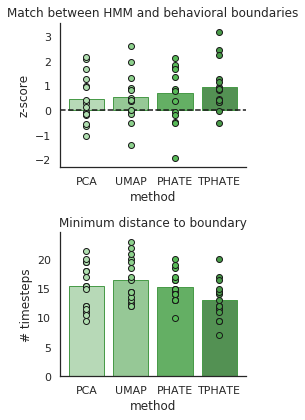

In [58]:
df = pd.read_csv("../results_final/behav_HMM_boundary_match.csv")

fig,ax=plt.subplots(2,1,figsize=(4, 6))
methods= ['PCA','UMAP','PHATE','TPHATE']

# ZSCORE RESULTS
g = sns.barplot(data=df, x='method', y='zscore', order =methods, 
              palette=pmc_colors[1:],  edgecolor=pmc_colors[-1],ax=ax[0],ci=None)

for i,meth in enumerate(methods):
    vals = df[df['method']==meth]['zscore'].values
    ax[0].scatter(x=np.ones(len(vals))*(i), y=vals, zorder=10, c=pmc_colors[i+1], edgecolor='k')
    
g.axhline(0,linestyle='--',color='k')
g.set(title='Match between HMM and behavioral boundaries', ylabel='z-score')

# MIN DIST TO BOUNDARY
g.set(title='Match between HMM and behavioral boundaries', ylabel='z-score')
g=sns.barplot(data=df, x='method', y='min_dist_med', order = ['PCA','UMAP','PHATE','TPHATE'], 
              palette=pmc_colors[1:], ax=ax[1],edgecolor=pmc_colors[-1],ci=None)

for i,meth in enumerate(methods):
    vals = df[df['method']==meth]['min_dist_med'].values
    ax[1].scatter(x=np.ones(len(vals))*(i), y=vals, zorder=10, c=pmc_colors[i+1], edgecolor='k')

g.set(title='Minimum distance to boundary', ylabel='# timesteps')
sns.despine(top=True, right=True)
fig.tight_layout()
plt.savefig('../plots/final_plots/match_behav.pdf', bbox_inches = "tight", transparent=True, format='pdf')

## HMM hyperparameters


In [54]:
df = pd.read_csv("../results_final/hmm_hyperparams.csv",index_col=0)
df.head()

,subject,ROI,dataset,CV_M,CV_K,embed_method
286,1,pmc_nn,forrest,3,111,PCA
287,2,pmc_nn,forrest,3,114,PCA
288,3,pmc_nn,forrest,3,106,PCA
289,4,pmc_nn,forrest,3,111,PCA
290,6,pmc_nn,forrest,3,114,PCA


In [55]:
df = pd.read_csv("../results_final/hmm_hyperparams.csv")
fn=None
for dataset in config.DATASETS:
    yname='CV_M'
    fn=f'../plots/final_plots/{dataset}_hmm_hyperparams.pdf'
    barplot_scatter_all_methods(df, dataset, yname, fn, 
                            ['PCA','UMAP','PHATE','TPHATE'], logscale=False, 
                           ylim=[0,6], scatter=False)

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>